**Intel Image Classification** - The best accuarcy is 92%

# Download dataset

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [111]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

In [113]:
import zipfile
zip_ref = zipfile.ZipFile('intel-image-classification.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

# Importing necessary libraries

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets
from torchvision import transforms, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [115]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Get the Intel images image data from the kaggle. Then split 20% of train-set as validation-set. 
The batch size is 64 that means 64 samples per batch to load.
Resize images to 150 * 150

In [116]:
train_path = '/content/files/seg_train' + '/seg_train'
test_path = '/content/files/seg_test' + '/seg_test'

transform = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])
trainset = datasets.ImageFolder(train_path, transform = transform)
testset = datasets.ImageFolder(test_path, transform = transform)

indexes = list(range(len(trainset)))
np.random.shuffle(indexes)
split_size = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indexes[:split_size])
valid_sample = SubsetRandomSampler(indexes[split_size:])

trainloader = DataLoader(trainset, sampler = train_sample, batch_size = 64)
validloader = DataLoader(trainset, sampler = valid_sample, batch_size = 64)
testloader = DataLoader(testset, batch_size = 64, shuffle = True)

# Visualize a Batch of Training Data

To see some images and their labels from train dataset I use matplotlib. Images and their labels are plotted.

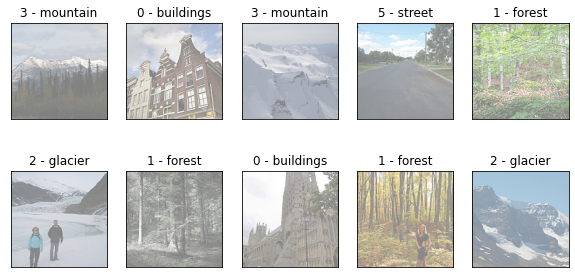

In [117]:
label_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

images, labels = next(iter(trainloader))
fig = plt.figure(figsize=(10,5))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    image = images[i].cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5 ,0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    plt.imshow(image)
    ax.set_title(str(labels[i].item())+' - '+label_names[labels[i].item()])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Define the train and test methods

This method will train the model. Forward and backward phases are implemented. At the end, train loss and validation loss are printed for each epoch.

In [118]:
def train(n_epochs, model, optimizer, criterion):
  model.train()
  
  for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    for data, target in trainloader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    for data, target in validloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)

    print('Epoch {} ---> Training Loss: {:.4f} \tValidation Loss: {:.4f}'.format(epoch + 1, train_loss, valid_loss))

Test the traind model with test dataset and report test loss, the accuracy for each class and overall accuracy.

In [119]:
def test(model, criterion):
  model.eval()

  class_correct = list(0. for i in range(6))
  class_total = list(0. for i in range(6))
  y_pred = []
  y_true = []
  test_loss = 0.0
  for data, target in testloader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      pred = output.argmax(1)
      correct = np.squeeze(pred.eq(target.data))
      i = 0
      for label in target.data:
          class_correct[label] += correct[i].item()
          class_total[label] += 1
          i += 1
          
      output = pred.data.cpu().numpy()
      y_pred.extend(output) 
      
      target = target.data.cpu().numpy()
      y_true.extend(target)
  test_loss = test_loss/len(testloader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(6):
      if class_total[i] > 0:
          print('Test Accuracy of label %2s: %2d%% (%2d/%2d)' % (
              str(i), 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
          
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
  # cf_matrix = confusion_matrix(y_true, y_pred)
  # df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 6, index = [i for i in label_names], columns = [i for i in label_names])
  # plt.figure(figsize = (6,6))
  # sn.heatmap(df_cm, annot=True)

# First Model


I use the pretrained resnet50 and add one linear layer at the end of this model to get output in range of 6 classes. Because this model has been trained, backpropagation must not be performed for its layers and just parameters os last layer should be updated.  

In [120]:
model1 = models.resnet50(pretrained=True)

for param in model1.parameters():
    param.required_grad = False

model1.fc = nn.Linear(model1.fc.in_features, 6)
model1.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Train the model with 5 epochs and using SGD optimizer with learning rate = 0.01 and crossEntropy as loss function.

In [121]:
n_epochs = 5
optimizer = optim.SGD(model1.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

train(n_epochs, model1, optimizer, criterion)

Epoch 1 ---> Training Loss: 0.8055 	Validation Loss: 0.3945
Epoch 2 ---> Training Loss: 0.2883 	Validation Loss: 0.2937
Epoch 3 ---> Training Loss: 0.1667 	Validation Loss: 0.2616
Epoch 4 ---> Training Loss: 0.1101 	Validation Loss: 0.2597
Epoch 5 ---> Training Loss: 0.0724 	Validation Loss: 0.2542


In [124]:
test(model1, criterion)

Test Loss: 0.257615

Test Accuracy of label  0: 91% (399/437)
Test Accuracy of label  1: 99% (470/474)
Test Accuracy of label  2: 85% (471/553)
Test Accuracy of label  3: 80% (424/525)
Test Accuracy of label  4: 98% (500/510)
Test Accuracy of label  5: 96% (482/501)

Test Accuracy (Overall): 91% (2746/3000)


# Second Model


Again resnet50 but now I add two linear layers with batch normalization at the end of the model.

In [125]:
model2 = models.resnet50(pretrained=True)

for param in model2.parameters():
    param.required_grad = False

model2.fc = nn.Sequential(
    nn.Linear(model2.fc.in_features, 64),
    nn.BatchNorm1d(64),
    nn.Linear(64 , 6),
)
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [126]:
n_epochs = 5
optimizer = optim.SGD(model2.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

train(n_epochs, model2, optimizer, criterion)

Epoch 1 ---> Training Loss: 0.5996 	Validation Loss: 0.3667
Epoch 2 ---> Training Loss: 0.2424 	Validation Loss: 0.3225
Epoch 3 ---> Training Loss: 0.1430 	Validation Loss: 0.3015
Epoch 4 ---> Training Loss: 0.0884 	Validation Loss: 0.2995
Epoch 5 ---> Training Loss: 0.0642 	Validation Loss: 0.3013


In [128]:
test(model2, criterion)

Test Loss: 0.284728

Test Accuracy of label  0: 92% (404/437)
Test Accuracy of label  1: 99% (471/474)
Test Accuracy of label  2: 80% (444/553)
Test Accuracy of label  3: 85% (451/525)
Test Accuracy of label  4: 95% (487/510)
Test Accuracy of label  5: 93% (466/501)

Test Accuracy (Overall): 90% (2723/3000)


# Third Model


I try the resNeXt50 and add just one linear layer at the end of the model.

In [129]:
model3 = models.resnext50_32x4d(pretrained=True)

for param in model3.parameters():
    param.required_grad = False

model3.fc = nn.Linear(model3.fc.in_features, 6)
model3.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [134]:
n_epochs = 8
optimizer = optim.SGD(model3.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

train(n_epochs, model3, optimizer, criterion)

Epoch 1 ---> Training Loss: 0.0277 	Validation Loss: 0.2618
Epoch 2 ---> Training Loss: 0.0197 	Validation Loss: 0.2604
Epoch 3 ---> Training Loss: 0.0138 	Validation Loss: 0.2699
Epoch 4 ---> Training Loss: 0.0109 	Validation Loss: 0.2679
Epoch 5 ---> Training Loss: 0.0106 	Validation Loss: 0.2825
Epoch 6 ---> Training Loss: 0.0108 	Validation Loss: 0.2976
Epoch 7 ---> Training Loss: 0.0063 	Validation Loss: 0.2907
Epoch 8 ---> Training Loss: 0.0058 	Validation Loss: 0.2924


In [135]:
test(model3, criterion)

Test Loss: 0.285816

Test Accuracy of label  0: 91% (402/437)
Test Accuracy of label  1: 99% (471/474)
Test Accuracy of label  2: 83% (460/553)
Test Accuracy of label  3: 86% (452/525)
Test Accuracy of label  4: 96% (494/510)
Test Accuracy of label  5: 96% (481/501)

Test Accuracy (Overall): 92% (2760/3000)


# Conclusion

In this notebook I tried 3 type of resnet and at least when I use the resNeXt and increase the number of epochs to 8, I reach the 92% accuracy.
Maybe by increasing the number of epochs more, the accuracy will improved.